# Movie Box Office Prediction

# Executure Summary

# 1. Introduction
## 1.1 Project Motivation
Cinema is a major cultural and economic force. It reflects societal values, provides entertainment, and generates significant revenue. Understanding the factors that drive a film's box office performance can help studios make informed decisions about production, marketing, and distribution. With the growing availability of structured metadata (e.g., cast, genre, release year) and user-generated feedback (e.g., IMDb ratings and votes), data-driven approaches can help uncover patterns that influence a movie’s financial outcome. In this project we plan to discover the elements that most significantly contribute to box office performance and explore whether revenue can be predicted using pre-release metadata and user reception indicators like reviews. 

## 1.2 Research Questions

We explore three interconnected questions:

1. *What factors have the most significant impact on movie revenue?*    
We investigate how metadata such as cast, director, genre, runtime, IMDb ratings, and budget correlate with financial success.  

2. *Can we predict movie revenue accurately using pre-release features (budget, cast, director)?*  
By using regression-based modeling, we test whether a combination of structured data available before release (e.g. genre, production budget, director, etc.) can offer a reasonably accurate estimate of box office performance.

3. *How do audience and critic reviews influence box office success?*   
Public feedback often affects a film’s long-term profitability. Here we examine how sentiment in reviews (when available) and IMDb-based audience metrics (e.g., votes, ratings) align with revenue outcomes.

# 2 Data Collection & Wrangling

## 2.1 Overview
The primary database was built using the OMDb API, which provided metadata and user ratings for **5000 movies**. To ensure a diverse and representative sample, we used a stratified sample from the TMDb file `movies_metadata.csv`, stratifying it by release year to cover a wide time range. We then queried the OMDb API for each selected title, storing key metadata including show time, genre, rating, and box office.  

However, due to limitations of the OMDb API, in particular, the lack of budget information - we augmented our dataset with the original TMDb metadata. After filtering and standardizing the records, we matched and added a budget values for over **3000 films**. The final merged dataset became the foundation for our exploratory analysis and modeling, combining comprehensive metadata with key financial indicators.

Code, notebooks, figures and scripts can be found in the [GitHub repository](https://github.com/CU-S25-MSDSSB-DSCI-01-DataScienceLab/Movie-Project?tab=readme-ov-file)  

Re-running the entire pipeline from scratch takes more than an hour (API calls + web-scraping), but a cleaned dataset (`data_collection/omdb_cleaned.csv`) is cached in the repository so the report can be reproduced in under 2 minutes. 


## 2.2 Building a 5000-film master list  
We relied on two main data sources: the OMDb API and the `movies_metadata.csv` dataframe from the *Kaggle* [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset). While OMDb provided reliable information on variables such as screening time, genre and IMDb rating, it lacked consistent box office data. To address this gap, we cross-referenced and merged budget data from TMDb where it possible.   

Given the huge number of movies available in TMDb (over 45000), we used a stratified sampling approach to ensure diversity. Specifically, we grouped films by year of release and randomly selected a proportional number of titles from each decade. 

| Strata | Levels |
|-------|--------|
| Decade | 1970s - 1980s - 1990s - 2000s - 2010s - 2020-24 |
| Budget tier (USD millions) | \<5 - 5-20 - 20-100 - \>100 |

This approach preserved the historical variability in film characteristics and revenue patterns while reducing the dataset to an acceptable size of about 5000 records. 

## 2.3 Metadata Enrichment & Merging
To obtain a rich and robust set of metadata, each title in our list of 5000 movies was queried through the OMDb API. A total of 4768 API calls were successful, and after removing duplicates, we retained 4688 unique records.  

However, a key limitation was discovered: approximately 40% of the OMDb records lacked valid revenue information. To address this problem, we applied a two-step enrichment process. First, we used the links.csv file from the original TMDb dataset to map IMDb identifiers to their counterparts in TMDb. This allowed us to directly query the TMDb API to retrieve the missing revenue data. Thus, we successfully retrieved box office data for an additional **1657 movies**, reducing the number of missing cases to 262. This enrichment step significantly improved the completeness of our financial variables while maintaining transparency.

## 2.4 Final Dataset and Quality Check 
After the metadata enrichment step, we performed a series of cleaning and validation steps to ensure the integrity of the analysis. Numeric fields such as `revenue`, `runtime`, and `budget` were normalized to the correct data types and distorted values were removed. All null values in the revenue field were treated as missing.  

The cleaned dataset includes **4688 unique films**, of which **3021** (about 64%) contain valid box office data. The remaining 1667 records were retained with missing revenue to allow for flexible treatment in modeling.

Key characteristics of the final dataset include:  
- The sample is both decade and budget-balanced, mitigating temporal or scale bias.  
- Roughly one-third of titles still lack revenue; we will treat *BoxOffice* as
    `NaN` in following analysis and test imputation vs. complete-case models.  
- IMDb ratings and votes have near-complete coverage (≥ 95 %) and show
    usable variance (mean ≈ 6.3, st.dev ≈ 1.1).  

# 3 Exploratory Data Analysis





In [32]:
#| echo: false        
#| message: false       
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

df = pd.read_csv(Path("data_collection/omdb_cleaned.csv"))
df["Runtime_clean"] = df["Runtime"].str.extract(r'(\d+)').astype(float)
df["Year"]          = pd.to_numeric(df["Year"], errors="coerce")

## 3.1 Missing-data Overview

To assess the completeness of the data, we visualized the pattern of missing values across all attributes (Figure 1). The vast majority of variables show a high level of coverage. The main exception is the `BoxOffice` variable, which is missing from about a third of the entries. This is consistent with earlier observations made during data collection. The heatmap highlights that the omissions are concentrated rather than random.

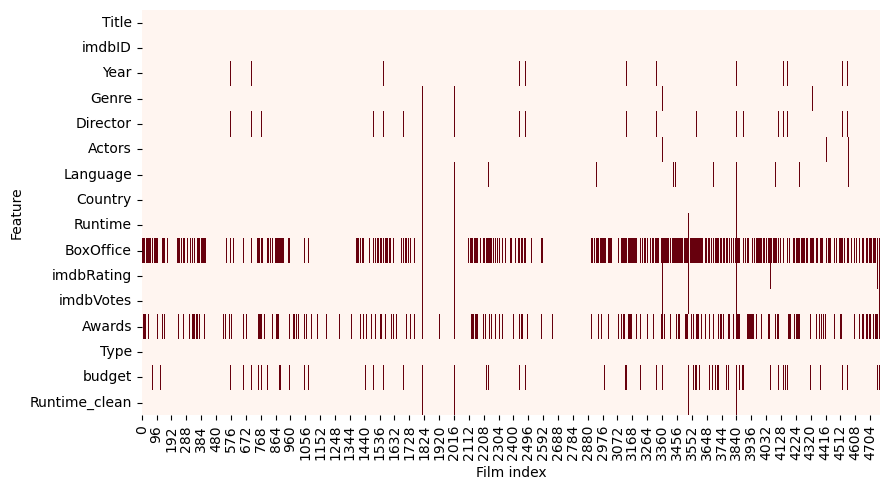

In [33]:
#| fig-cap: "Figure 1 · Missing-value heat-map (darker = missing)."
plt.figure(figsize=(9,5))
sns.heatmap(df.isna().T, cbar=False, cmap="Reds")
plt.xlabel("Film index"); plt.ylabel("Feature")
plt.tight_layout()

## 3.2 IMDb rating vs. BoxOffice availability

Next, we investigated whether movies with missing revenue data differ from movies with specified values. Figure 2 compares IMDb ratings between the two groups.

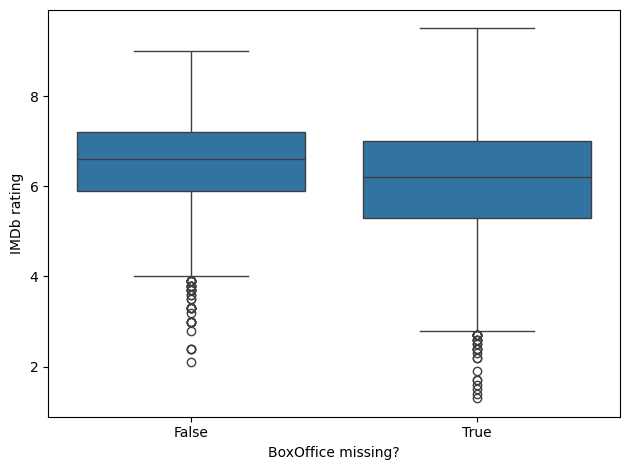

In [34]:
#| fig-cap: "Figure 2 · IMDb ratings are similar whether revenue is missing or not."
df["boxoffice_missing"] = df["BoxOffice"].isna()
sns.boxplot(x="boxoffice_missing", y="imdbRating", data=df)
plt.xlabel("BoxOffice missing?"); plt.ylabel("IMDb rating")
plt.tight_layout()

This suggests that the presence or absence of BoxOffice data does not correlate with the perceived quality of a movie, reducing concerns about selection bias.  

## 3.3 Key univariate distributions
### 3.3.1 Genre frequency – top 10
To better understand the thematic distribution of our dataset, we examined the frequency of movie genres (Figure 3).

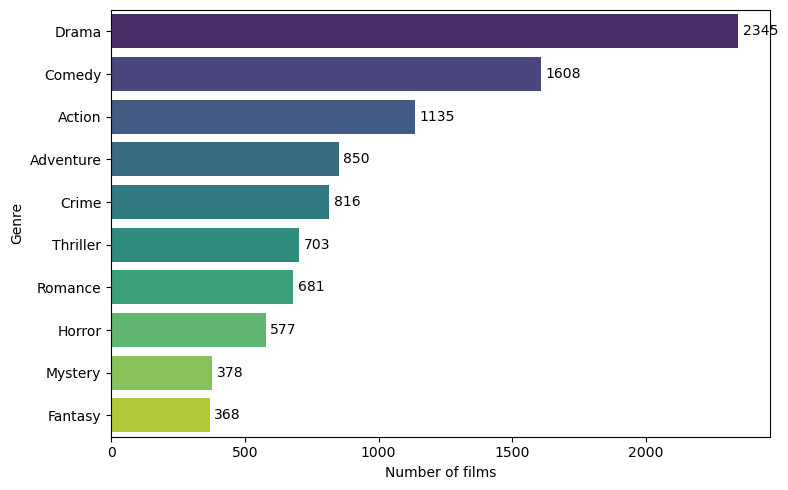

In [35]:
#| fig-cap: "Figure 3 · Top-10 genres across 4 688 films."
from collections import Counter
genre_counts = Counter(g for s in df["Genre"].dropna() for g in s.split(", "))
top = pd.DataFrame(genre_counts.most_common(10), columns=["Genre", "Count"])

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=top, y="Genre", x="Count", hue="Genre", palette="viridis", dodge=False)
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.xlabel("Number of films")
plt.tight_layout()
plt.show()

The most common categories are **drama**, **comedy**, and **action**, a trend that reflects industry production volumes. The diversity of genres ensures that our modeling will reflect a wide range of narrative and stylistic patterns, allowing us to gain a deeper understanding of how content type can influence box office receipts.

### 3.3.2 Language frequency – top 10

As far as languages are concerned, the picture is very clear. English has a larger share than all other languages combined.

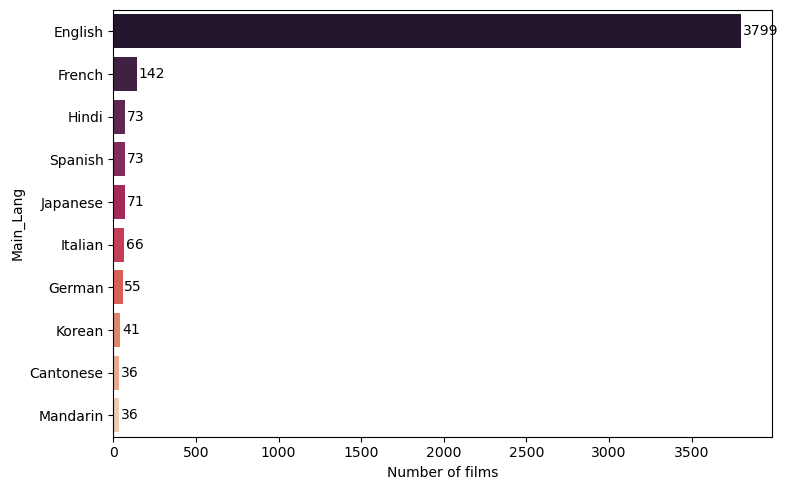

In [36]:
#| fig-cap: "Figure 4 · Most common primary languages."
df["Main_Lang"] = df["Language"].dropna().str.split(",").str[0]
top_lang = df["Main_Lang"].value_counts().head(10)
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=top_lang.values, y=top_lang.index, hue=top_lang.index, palette="rocket", dodge=False)

for i, v in enumerate(top_lang.values):
    ax.text(v + 10, i, str(v), color='black', va='center')  # Adjust `+10` as needed

plt.xlabel("Number of films")
plt.tight_layout()
plt.show()

## 3.4 Revenue distributions

Given the wide variability in film profitability, we examined the distribution of reported box office revenue using a log-scaled histogram (Figure 5). Most films in the dataset earn under **$10 million**, with a long right tail reflecting the presence of highly successful blockbusters. The log transformation reveals the density structure more clearly and confirms the classic skewed nature of movie earnings, where a few titles dominate total revenue.

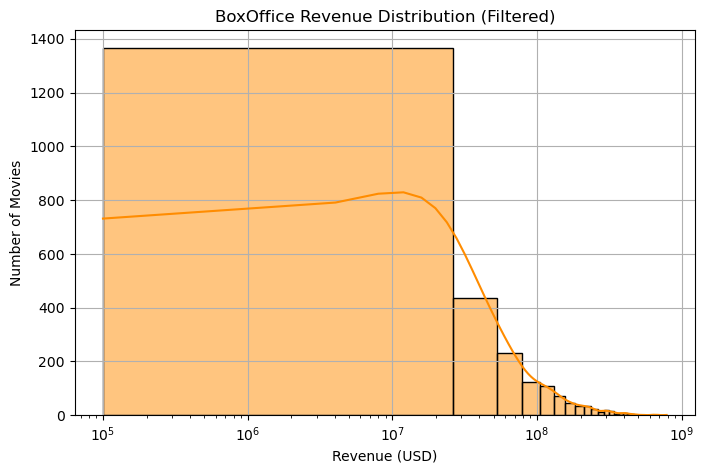

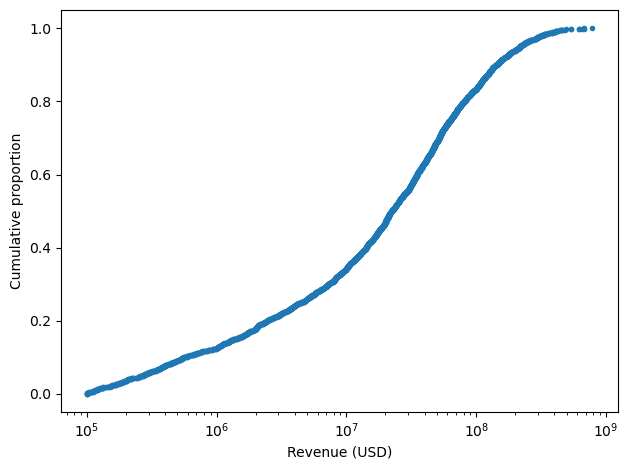

In [37]:
#| fig-cap: "Figure 5 · Histogram of BoxOffice revenue (log ₁₀ scale, >$100 k)."
filtered_df = df[df["BoxOffice"] > 100_000]

plt.figure(figsize=(8, 5))
sns.histplot(filtered_df["BoxOffice"], bins=30, kde=True, color="darkorange")
plt.xscale("log")
plt.title("BoxOffice Revenue Distribution (Filtered)")
plt.xlabel("Revenue (USD)")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

#| fig-cap: "Figure 6 · ECDF of revenues (log ₁₀ scale)."
bo = df.loc[mask, "BoxOffice"].sort_values()
y  = np.arange(1, len(bo)+1) / len(bo)
plt.plot(bo, y, marker=".", linestyle="none")
plt.xscale("log"); plt.xlabel("Revenue (USD)")
plt.ylabel("Cumulative proportion")
plt.tight_layout()

To better understand the concentration of revenues among high-performing films, we plotted the empirical cumulative distribution function curve in Figure 6. The curve shows that about **80%** of all box office receipts are accounted for by only **20%** of films, highlighting the extreme imbalance in commercial success.  

## 3.5 Correlation heat-map

A correlation heatmap was used to quantify relationships between key numerical variables (Figure 7). **Budget** and **IMDb votes** elicit the strongest positive correlation with box office revenue, which suggesting that larger production investment and greater audience engagement are strong predictors of financial performance.   

IMDb rating, while positively correlated, shows a weaker association, indicating that popularity (vote count) may be more financially consequential than average rating alone. These insights guide feature selection for subsequent modeling.

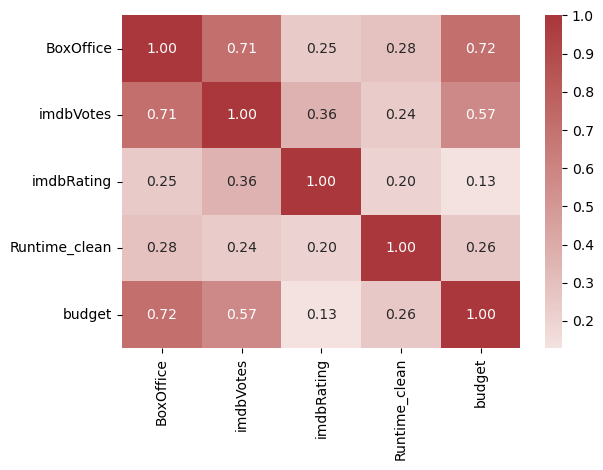

In [39]:
#| fig-cap: "Figure 7 · Correlation among numeric variables."
num_cols = ["BoxOffice","imdbVotes","imdbRating","Runtime_clean","budget"]
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="vlag", center=0)
plt.tight_layout()

## 2.6 Genre and decade effects on revenue

Next we examined how revenues vary across genres and historical periods. Figure 8 shows the average box office receipts for the ten most financially successful genres in the dataset. It is dominated by genres such as **animation**, **adventure**, and **action**, which are often associated with family blockbusters or movie franchises. This hints us on the fact that genre plays an important role in shaping a film's commercial potential and also emphasizes the importance of considering content type in revenue forecasting models.

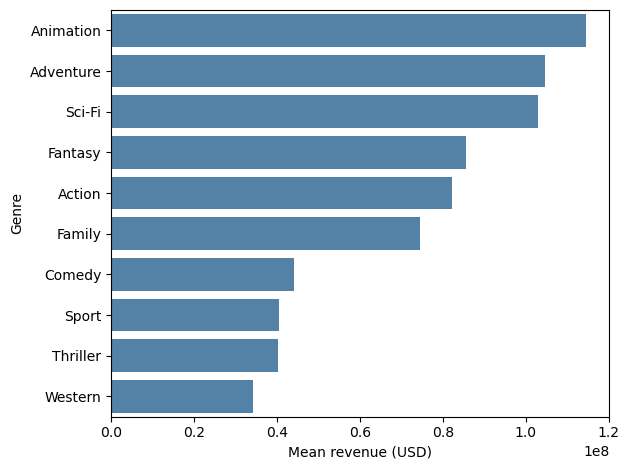

In [ ]:
#| fig-cap: "Figure 8 · Mean revenue by genre (top 10)."
exploded = df.assign(Genre=df["Genre"].str.split(", ")).explode("Genre")
top10    = exploded.groupby("Genre")["BoxOffice"].mean().nlargest(10)
sns.barplot(x=top10.values, y=top10.index, color="steelblue")
plt.xlabel("Mean revenue (USD)"); plt.tight_layout()

Figure 9 shows the evolution of median revenues by decade, based on log transformed values to remove extreme skewness in revenues. The graph shows a gradual upward shift over time. Especially, starting in the **1950s**. This trend likely reflects both inflation and the increasing global reach of the movie market. However, the dispersion remains large in all periods, meaning that highs and lows coexist in each era. 

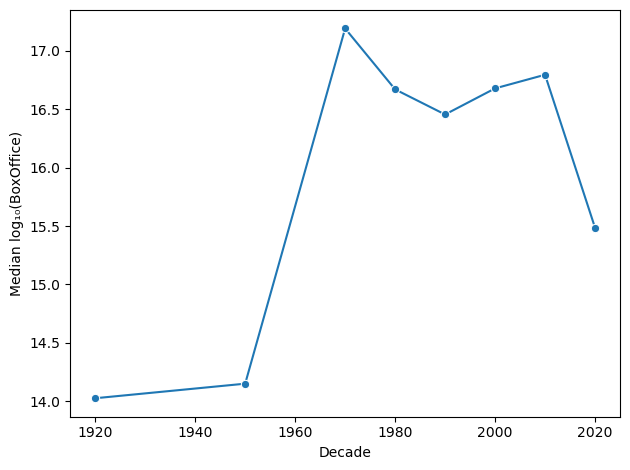

In [41]:
#| fig-cap: "Figure 9 · Median revenue trend by decade."
df["Decade"] = (df["Year"]//10)*10
dec_med = df.groupby("Decade")["BoxOffice"].median().dropna()
sns.lineplot(x=dec_med.index, y=np.log1p(dec_med), marker="o")
plt.xlabel("Decade"); plt.ylabel("Median log₁₀(BoxOffice)")
plt.tight_layout()
